In [ ]:
import os
import time
import copy
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch.optim import lr_scheduler
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import random
from PIL import Image
from tqdm import tqdm
from collections import Counter
import albumentations as A

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

C:\Users\walam\anaconda3\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\walam\anaconda3\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


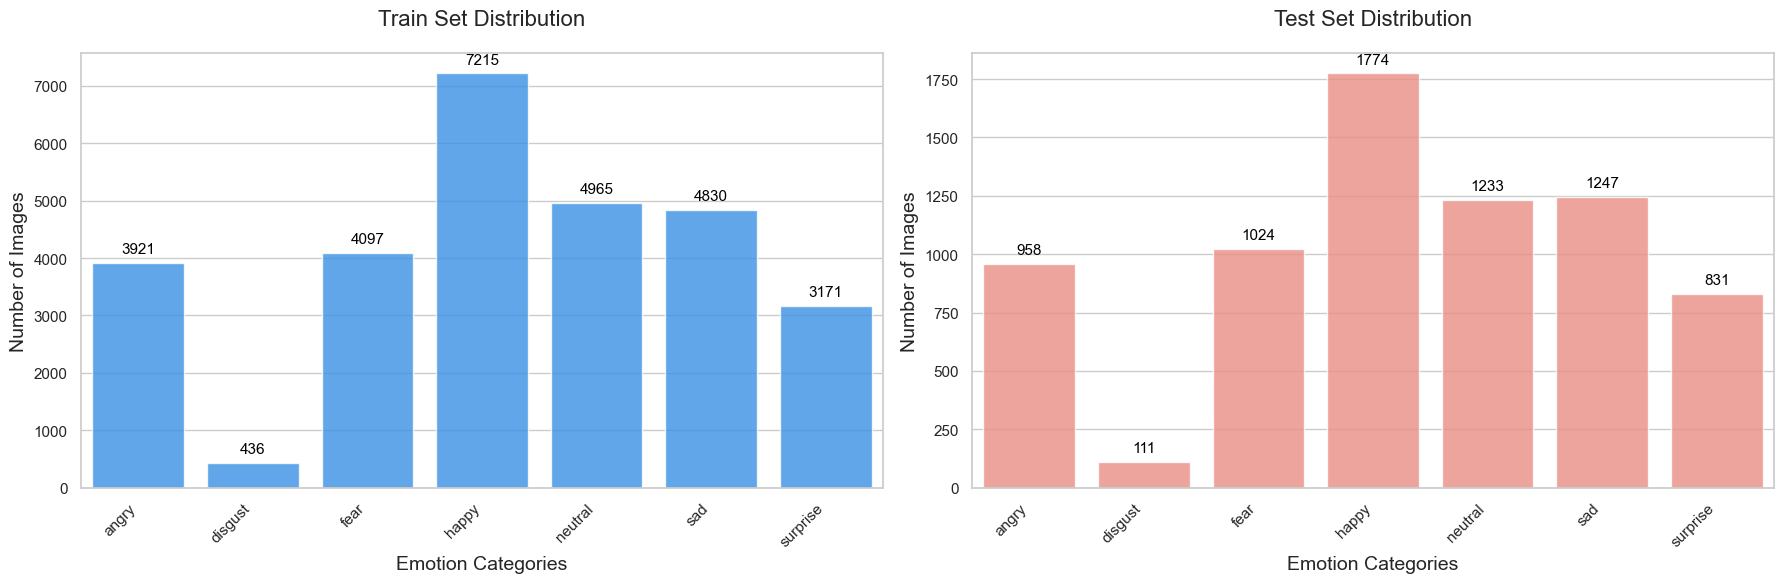


=== Dataset Statistics ===
Total train images: 28635
Total test images: 7178
Total images in dataset: 35813

Train Set Distribution:
angry: 3921 images (13.7%)
disgust: 436 images (1.5%)
fear: 4097 images (14.3%)
happy: 7215 images (25.2%)
neutral: 4965 images (17.3%)
sad: 4830 images (16.9%)
surprise: 3171 images (11.1%)

Test Set Distribution:
angry: 958 images (13.3%)
disgust: 111 images (1.5%)
fear: 1024 images (14.3%)
happy: 1774 images (24.7%)
neutral: 1233 images (17.2%)
sad: 1247 images (17.4%)
surprise: 831 images (11.6%)


In [38]:
# EDA for Emotion Recognition Dataset - Separate Plots

# Set up paths
data_dir =  "C:/facial expressions"  # Your root directory
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

# Get emotion categories
emotions = sorted(os.listdir(train_dir))

# Count images per emotion
train_counts = {emotion: len(os.listdir(os.path.join(train_dir, emotion))) for emotion in emotions}
test_counts = {emotion: len(os.listdir(os.path.join(test_dir, emotion))) for emotion in emotions}

# Calculate totals
total_train = sum(train_counts.values())
total_test = sum(test_counts.values())

# Set style
sns.set(style="whitegrid")
plt.figure(figsize=(18, 6))

# --------------------------
# First Plot - Train Distribution
# --------------------------
plt.subplot(1, 2, 1)
ax1 = sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()),
                color="dodgerblue", alpha=0.8)
plt.title("Train Set Distribution", fontsize=16, pad=20)
plt.xlabel("Emotion Categories", fontsize=14)
plt.ylabel("Number of Images", fontsize=14)
plt.xticks(rotation=45, ha='right')

# Add annotations
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                fontsize=11, color='black',
                xytext=(0, 5),
                textcoords='offset points')

# --------------------------
# Second Plot - Test Distribution
# --------------------------
plt.subplot(1, 2, 2)
ax2 = sns.barplot(x=list(test_counts.keys()), y=list(test_counts.values()),
                color="salmon", alpha=0.8)
plt.title("Test Set Distribution", fontsize=16, pad=20)
plt.xlabel("Emotion Categories", fontsize=14)
plt.ylabel("Number of Images", fontsize=14)
plt.xticks(rotation=45, ha='right')

# Add annotations
for p in ax2.patches:
    ax2.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                fontsize=11, color='black',
                xytext=(0, 5),
                textcoords='offset points')

plt.tight_layout()
plt.show()

# Print statistics
print("\n=== Dataset Statistics ===")
print(f"Total train images: {total_train}")
print(f"Total test images: {total_test}")
print(f"Total images in dataset: {total_train + total_test}\n")

print("Train Set Distribution:")
for emotion, count in train_counts.items():
    print(f"{emotion}: {count} images ({count/total_train*100:.1f}%)")

print("\nTest Set Distribution:")
for emotion, count in test_counts.items():
    print(f"{emotion}: {count} images ({count/total_test*100:.1f}%)")

In [ ]:
# we augment data to make it balanced 

# Paths
dataset_path = "/facial expressions/train"
output_path = "/augmented facial expressions/train"

# Albumentations transforms (preserving 48x48 size)
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Rotate(limit=15, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.5),
    A.GaussNoise(p=0.2),
    A.Blur(blur_limit=1, p=0.1),
    A.Resize(48, 48)  # ensure final size is still 48x48
])

# Count images per class
class_counts = {}
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        class_counts[class_name] = len(os.listdir(class_dir))

max_count = max(class_counts.values())

print("Original class distribution:", class_counts)

# Balancing dataset
for class_name, count in tqdm(class_counts.items(), desc="Balancing classes"):
    class_dir = os.path.join(dataset_path, class_name)
    images = os.listdir(class_dir)
    needed = max_count - count

    output_class_dir = os.path.join(output_path, class_name)
    os.makedirs(output_class_dir, exist_ok=True)

    # Copy original images
    for img_name in images:
        img_path = os.path.join(class_dir, img_name)
        out_path = os.path.join(output_class_dir, img_name)
        if not os.path.exists(out_path):
            Image.open(img_path).save(out_path)

    # Create augmented images
    for i in range(needed):
        img_name = random.choice(images)
        img_path = os.path.join(class_dir, img_name)

        with Image.open(img_path) as img:
            img = img.convert("RGB")
            img_np = np.array(img)

            augmented = augment(image=img_np)['image']
            aug_img = Image.fromarray(augmented)
            aug_img_name = f"aug_{i}_{img_name}"
            aug_img.save(os.path.join(output_class_dir, aug_img_name))

print("✅ Dataset balanced with 48x48 image augmentations!")


C:\Users\walam\anaconda3\lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
C:\Users\walam\anaconda3\lib\site-packages\albumentations\core\validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\walam\anaconda3\lib\site-packages\albumentations\augmentations\blur\functional.py:147: UserWarning: blur_limit: Invalid kernel size range (3, 1). Values less than 3 are not allowed. Range automatically adjusted to (3, 3).
  result = _ensure_min_value(result, min_value, info.field_name)


Original class distribution: {'angry': 3921, 'disgust': 436, 'fear': 4097, 'happy': 7215, 'neutral': 4965, 'sad': 4830, 'surprise': 3171}


Balancing classes: 100%|██████████| 7/7 [01:18<00:00, 11.23s/it]

✅ Dataset balanced with 48x48 image augmentations!


C:\Users\walam\anaconda3\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\walam\anaconda3\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


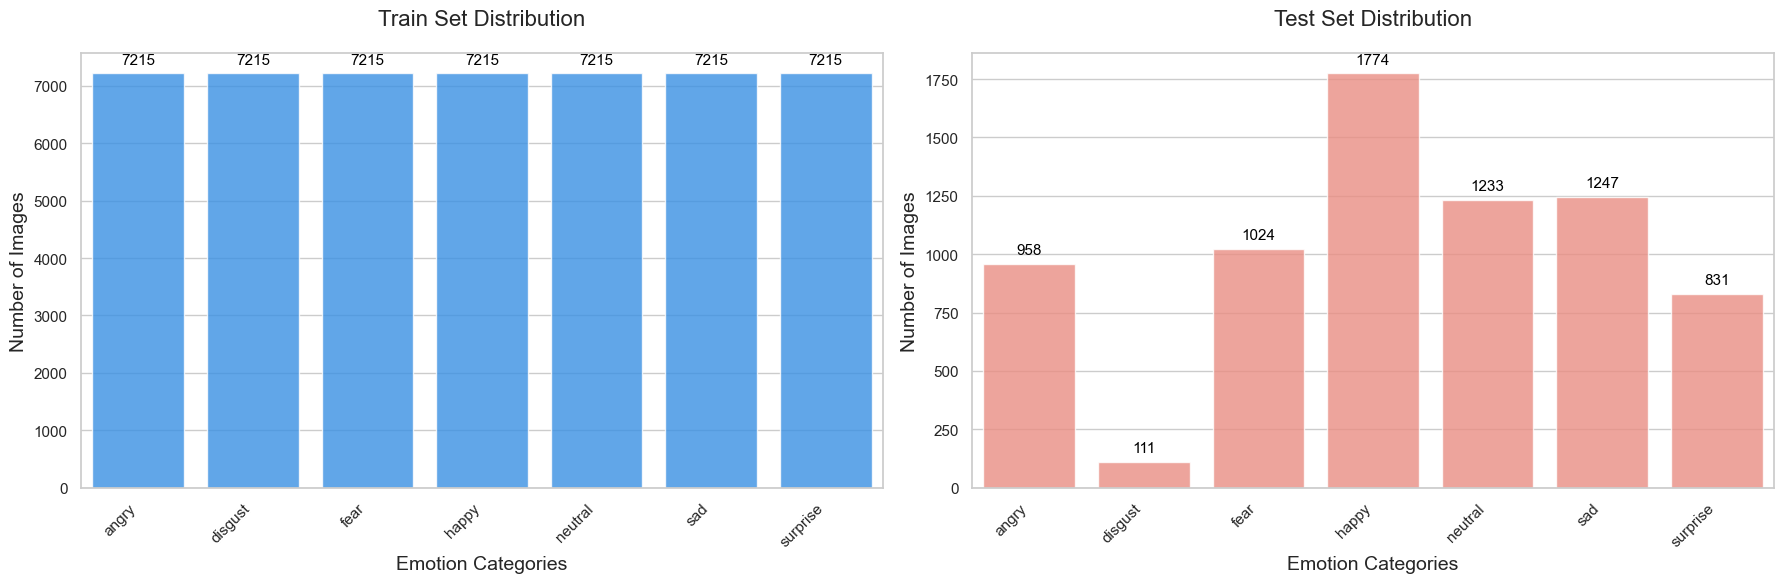


=== Dataset Statistics ===
Total train images: 50505
Total test images: 7178
Total images in dataset: 57683

Train Set Distribution:
angry: 7215 images (14.3%)
disgust: 7215 images (14.3%)
fear: 7215 images (14.3%)
happy: 7215 images (14.3%)
neutral: 7215 images (14.3%)
sad: 7215 images (14.3%)
surprise: 7215 images (14.3%)

Test Set Distribution:
angry: 958 images (13.3%)
disgust: 111 images (1.5%)
fear: 1024 images (14.3%)
happy: 1774 images (24.7%)
neutral: 1233 images (17.2%)
sad: 1247 images (17.4%)
surprise: 831 images (11.6%)


In [40]:


# Set up paths
data_dir =  "/augmented facial expressions"  # Your root directory
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

# Get emotion categories
emotions = sorted(os.listdir(train_dir))

# Count images per emotion
train_counts = {emotion: len(os.listdir(os.path.join(train_dir, emotion))) for emotion in emotions}
test_counts = {emotion: len(os.listdir(os.path.join(test_dir, emotion))) for emotion in emotions}

# Calculate totals
total_train = sum(train_counts.values())
total_test = sum(test_counts.values())

# Set style
sns.set(style="whitegrid")
plt.figure(figsize=(18, 6))

# --------------------------
# First Plot - Train Distribution
# --------------------------
plt.subplot(1, 2, 1)
ax1 = sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()),
                color="dodgerblue", alpha=0.8)
plt.title("Train Set Distribution", fontsize=16, pad=20)
plt.xlabel("Emotion Categories", fontsize=14)
plt.ylabel("Number of Images", fontsize=14)
plt.xticks(rotation=45, ha='right')

# Add annotations
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                fontsize=11, color='black',
                xytext=(0, 5),
                textcoords='offset points')

# --------------------------
# Second Plot - Test Distribution
# --------------------------
plt.subplot(1, 2, 2)
ax2 = sns.barplot(x=list(test_counts.keys()), y=list(test_counts.values()),
                color="salmon", alpha=0.8)
plt.title("Test Set Distribution", fontsize=16, pad=20)
plt.xlabel("Emotion Categories", fontsize=14)
plt.ylabel("Number of Images", fontsize=14)
plt.xticks(rotation=45, ha='right')

# Add annotations
for p in ax2.patches:
    ax2.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                fontsize=11, color='black',
                xytext=(0, 5),
                textcoords='offset points')

plt.tight_layout()
plt.show()

# Print statistics
print("\n=== Dataset Statistics ===")
print(f"Total train images: {total_train}")
print(f"Total test images: {total_test}")
print(f"Total images in dataset: {total_train + total_test}\n")

print("Train Set Distribution:")
for emotion, count in train_counts.items():
    print(f"{emotion}: {count} images ({count/total_train*100:.1f}%)")

print("\nTest Set Distribution:")
for emotion, count in test_counts.items():
    print(f"{emotion}: {count} images ({count/total_test*100:.1f}%)")

In [5]:
data_dir = "/augmented facial expressions/train"
test_dir = '/facial expressions/test'

# --- Transforms ---
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}



In [6]:
# --- Load dataset and split into train/val ---
full_dataset = datasets.ImageFolder(data_dir, transform=data_transforms['train'])
class_names = full_dataset.classes
n_classes = len(class_names)

val_size = int(0.2 * len(full_dataset))
train_size = len(full_dataset) - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Apply validation transforms manually
val_dataset.dataset.transform = data_transforms['val']

# Test dataset
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

In [7]:
print(train_size)

42084


In [7]:
# --- DataLoaders ---
batch_size = 64
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2),
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2),
    'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
}

datasets_map = {
    'train': train_dataset,
    'val': val_dataset,
    'test': test_dataset
}

In [8]:
# --- Compute Class Weights ---
train_labels = [label for _, label in train_dataset]
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

In [10]:
# --- Model Loader ---
def load_model(model_name):
    if model_name == 'mobilenet_v2':
        model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
        for param in model.features.parameters():
            param.requires_grad = False
        for param in model.features[-5:].parameters():
            param.requires_grad = True
        model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(model.last_channel, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, n_classes)
        )

    elif model_name == 'efficientnet_b0':
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        for param in model.features.parameters():
            param.requires_grad = False
        for param in model.features[-5:].parameters():
            param.requires_grad = True
        num_ftrs = model.classifier[1].in_features
        model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),

            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),



            nn.Dropout(0.3),
            nn.Linear(256, n_classes)

        )

    elif model_name == 'resnet18':
        model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

       # Freeze all layers
        for param in model.parameters():
            param.requires_grad = False

    # Unfreeze the last residual block (layer4)
        for param in model.layer4.parameters():
            param.requires_grad = True

        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, n_classes)
    )

    elif model_name == 'googlenet':
        model = models.googlenet(weights=models.GoogLeNet_Weights.IMAGENET1K_V1)
        for name, param in model.named_parameters():
            if 'inception5b' in name or 'fc' in name:
                param.requires_grad = True
            else:
                param.requires_grad = False
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.4),

            nn.Linear(512, 256),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),
            nn.Linear(256, n_classes)
        )

    else:
        raise ValueError(f"Unsupported model: {model_name}")

    return model.to(device)


In [ ]:
print(n_classes)

In [11]:
# --- Training Loop ---
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=5):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase], desc=phase):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(datasets_map[phase])
            epoch_acc = running_corrects.double() / len(datasets_map[phase])

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

            if scheduler and phase == 'train':
                scheduler.step(epoch_loss)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)
    return model, history


In [12]:
# --- Plot Training Curves ---
def plot_training_curves(history, model_name="Model"):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['val_acc'], label='Val Acc', color='orange')
    plt.title(f'{model_name} Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss', color='blue')
    plt.title(f'{model_name} Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [13]:
# --- Evaluation ---
def evaluate(model):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloaders['test'], desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # --- Classification Report ---
    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # --- Confusion Matrix ---
    cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(class_names))))

    # --- Custom Confusion Matrix Plot ---
    def plot_confusion_matrix(cm, target_names, title='Confusion Matrix', cmap=plt.cm.Greens):
        plt.figure(figsize=(10, 10))
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title, fontsize=16)
        plt.colorbar()
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45, ha='right')
        plt.yticks(tick_marks, target_names)

        width, height = cm.shape
        for x in range(width):
            for y in range(height):
                plt.text(y, x, format(cm[x][y], 'd'),
                         horizontalalignment="center",
                         verticalalignment="center",
                         color="black")

        plt.tight_layout()
        plt.ylabel('True Label', fontsize=12)
        plt.xlabel('Predicted Label', fontsize=12)
        plt.show()
    # --- Call Plot ---
    plot_confusion_matrix(cm, class_names)





=== Training efficientnet_b0 ===
Epoch 1/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 1.3034 Acc: 0.5030


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.0653 Acc: 0.5882
Epoch 2/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 1.0493 Acc: 0.6053


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 0.9942 Acc: 0.6124
Epoch 3/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 0.9674 Acc: 0.6358


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 0.9387 Acc: 0.6434
Epoch 4/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 0.9073 Acc: 0.6577


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 0.9213 Acc: 0.6426
Epoch 5/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 0.8663 Acc: 0.6749


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 0.8988 Acc: 0.6556
Epoch 6/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 0.8311 Acc: 0.6887


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 0.8871 Acc: 0.6603
Epoch 7/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 0.7990 Acc: 0.7005


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 0.8999 Acc: 0.6585
Epoch 8/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 0.7686 Acc: 0.7153


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 0.9032 Acc: 0.6670
Epoch 9/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 0.7473 Acc: 0.7240


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 0.8761 Acc: 0.6744
Epoch 10/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 0.7186 Acc: 0.7338


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 0.8409 Acc: 0.6816
Epoch 11/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 0.6904 Acc: 0.7461


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 0.8437 Acc: 0.6943
Epoch 12/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 0.6660 Acc: 0.7552


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 0.8564 Acc: 0.6900
Epoch 13/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 0.6454 Acc: 0.7630


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 0.8821 Acc: 0.6862
Epoch 14/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 0.6198 Acc: 0.7713


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 0.8448 Acc: 0.7004
Epoch 15/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 0.5952 Acc: 0.7821


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 0.8347 Acc: 0.6977
Epoch 16/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 0.5809 Acc: 0.7897


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 0.8290 Acc: 0.6983
Epoch 17/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 0.5555 Acc: 0.7998


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 0.8008 Acc: 0.7176
Epoch 18/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 0.5388 Acc: 0.8048


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 0.8078 Acc: 0.7186
Epoch 19/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 0.5257 Acc: 0.8086


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 0.7990 Acc: 0.7237
Epoch 20/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 0.5044 Acc: 0.8174


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 0.8254 Acc: 0.7209


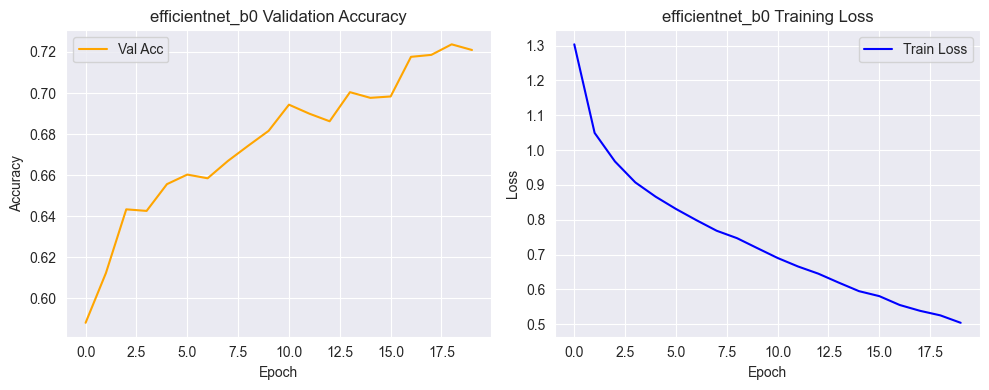

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]


Classification Report:

              precision    recall  f1-score   support

       angry       0.61      0.53      0.57       958
     disgust       0.80      0.63      0.71       111
        fear       0.48      0.54      0.51      1024
       happy       0.86      0.86      0.86      1774
     neutral       0.59      0.67      0.63      1233
         sad       0.56      0.48      0.52      1247
    surprise       0.77      0.80      0.79       831

    accuracy                           0.66      7178
   macro avg       0.67      0.64      0.65      7178
weighted avg       0.66      0.66      0.66      7178



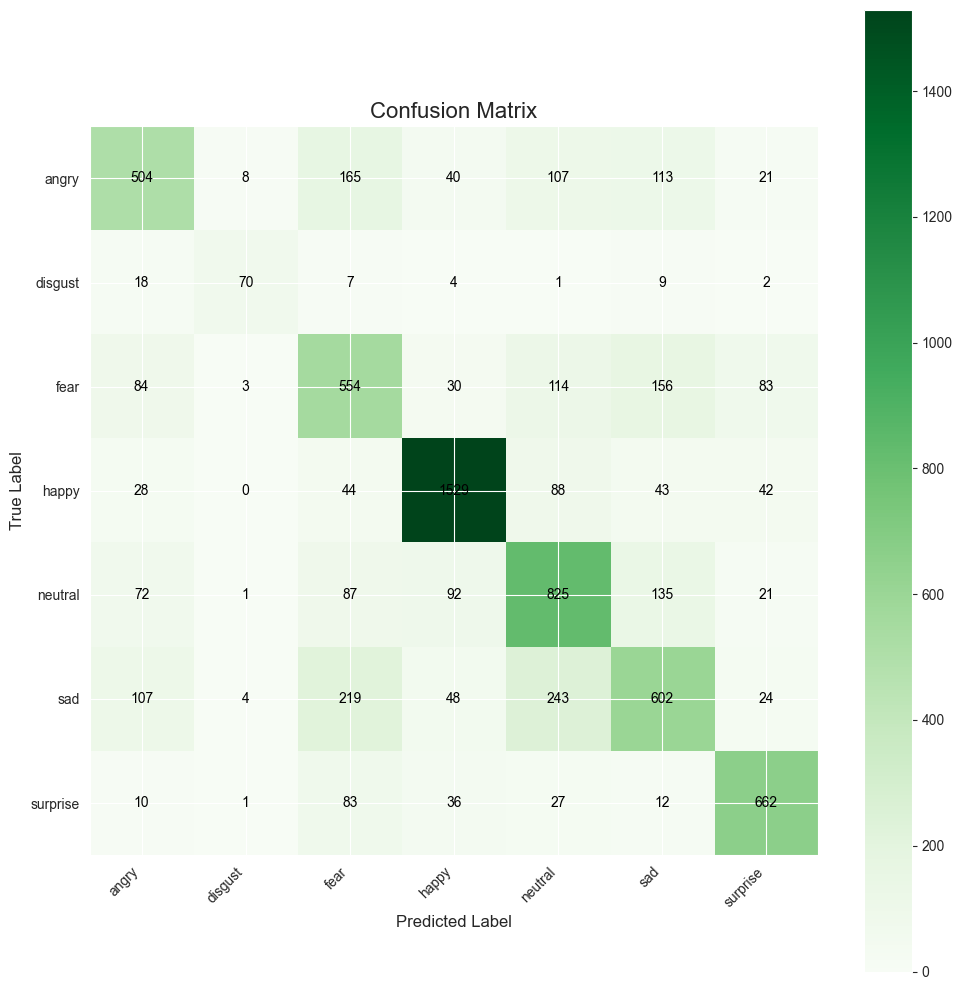


=== Training resnet18 ===
Epoch 1/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 1.3675 Acc: 0.4720


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.2712 Acc: 0.5024
Epoch 2/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 1.1622 Acc: 0.5561


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.1231 Acc: 0.5645
Epoch 3/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 1.0850 Acc: 0.5874


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.0530 Acc: 0.5884
Epoch 4/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 1.0298 Acc: 0.6075


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.0423 Acc: 0.5921
Epoch 5/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 0.9777 Acc: 0.6307


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.0078 Acc: 0.6132
Epoch 6/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 0.9321 Acc: 0.6472


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.0420 Acc: 0.6045
Epoch 7/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 0.9016 Acc: 0.6616


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 0.9884 Acc: 0.6217
Epoch 8/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 0.8581 Acc: 0.6789


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.0145 Acc: 0.6181
Epoch 9/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 0.8331 Acc: 0.6898


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 0.9774 Acc: 0.6266
Epoch 10/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 0.7992 Acc: 0.7025


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 0.9713 Acc: 0.6356
Epoch 11/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 0.7693 Acc: 0.7167


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 0.9521 Acc: 0.6405
Epoch 12/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 0.7348 Acc: 0.7297


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 0.9448 Acc: 0.6471
Epoch 13/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 0.7171 Acc: 0.7352


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 0.9653 Acc: 0.6423
Epoch 14/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 0.6898 Acc: 0.7467


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 0.9418 Acc: 0.6557
Epoch 15/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 0.6667 Acc: 0.7545


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 0.9533 Acc: 0.6540
Epoch 16/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 0.6482 Acc: 0.7619


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 0.9429 Acc: 0.6542
Epoch 17/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 0.6257 Acc: 0.7711


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 0.9470 Acc: 0.6595
Epoch 18/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 0.6104 Acc: 0.7776


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 0.9887 Acc: 0.6419
Epoch 19/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 0.6040 Acc: 0.7796


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 0.9408 Acc: 0.6651
Epoch 20/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 0.5825 Acc: 0.7887


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 0.9721 Acc: 0.6598


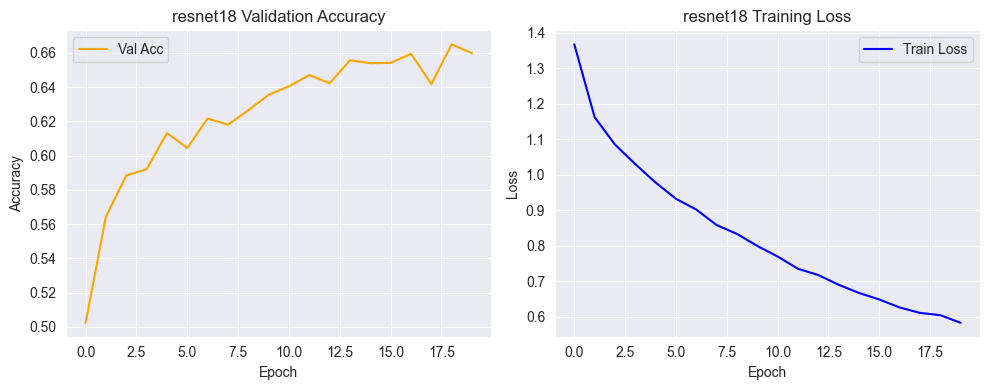

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]


Classification Report:

              precision    recall  f1-score   support

       angry       0.49      0.61      0.54       958
     disgust       0.75      0.55      0.64       111
        fear       0.41      0.48      0.45      1024
       happy       0.82      0.84      0.83      1774
     neutral       0.59      0.56      0.58      1233
         sad       0.54      0.41      0.47      1247
    surprise       0.76      0.73      0.75       831

    accuracy                           0.62      7178
   macro avg       0.63      0.60      0.61      7178
weighted avg       0.62      0.62      0.62      7178



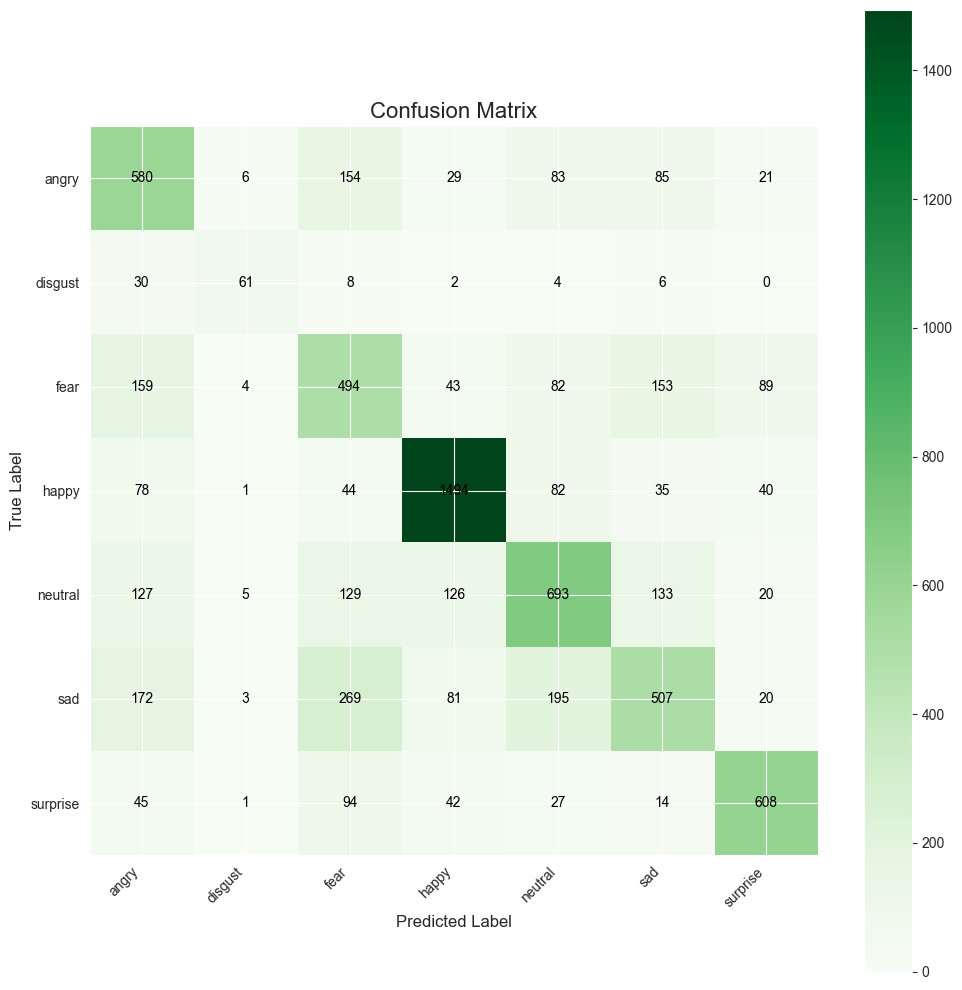


=== Training googlenet ===
Epoch 1/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 1.5927 Acc: 0.3763


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.4598 Acc: 0.4369
Epoch 2/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 1.4319 Acc: 0.4463


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.3719 Acc: 0.4587
Epoch 3/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 1.3674 Acc: 0.4732


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.3459 Acc: 0.4722
Epoch 4/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 1.3252 Acc: 0.4860


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.3106 Acc: 0.4872
Epoch 5/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 1.2917 Acc: 0.5008


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.2905 Acc: 0.4908
Epoch 6/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 1.2636 Acc: 0.5120


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.2490 Acc: 0.5091
Epoch 7/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 1.2393 Acc: 0.5206


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.2326 Acc: 0.5179
Epoch 8/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 1.2183 Acc: 0.5324


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.2361 Acc: 0.5131
Epoch 9/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 1.2076 Acc: 0.5352


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.2289 Acc: 0.5197
Epoch 10/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 1.1885 Acc: 0.5417


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.2106 Acc: 0.5284
Epoch 11/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 1.1687 Acc: 0.5488


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.1842 Acc: 0.5328
Epoch 12/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 1.1581 Acc: 0.5527


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.1928 Acc: 0.5372
Epoch 13/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 1.1470 Acc: 0.5576


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.1920 Acc: 0.5326
Epoch 14/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 1.1404 Acc: 0.5604


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.1808 Acc: 0.5381
Epoch 15/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 1.1294 Acc: 0.5661


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.1812 Acc: 0.5344
Epoch 16/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 1.1185 Acc: 0.5673


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.1708 Acc: 0.5446
Epoch 17/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 1.1050 Acc: 0.5760


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.1595 Acc: 0.5478
Epoch 18/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 1.0971 Acc: 0.5791


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.1593 Acc: 0.5533
Epoch 19/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 1.0886 Acc: 0.5830


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.1768 Acc: 0.5470
Epoch 20/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 1.0844 Acc: 0.5826


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.1647 Acc: 0.5387


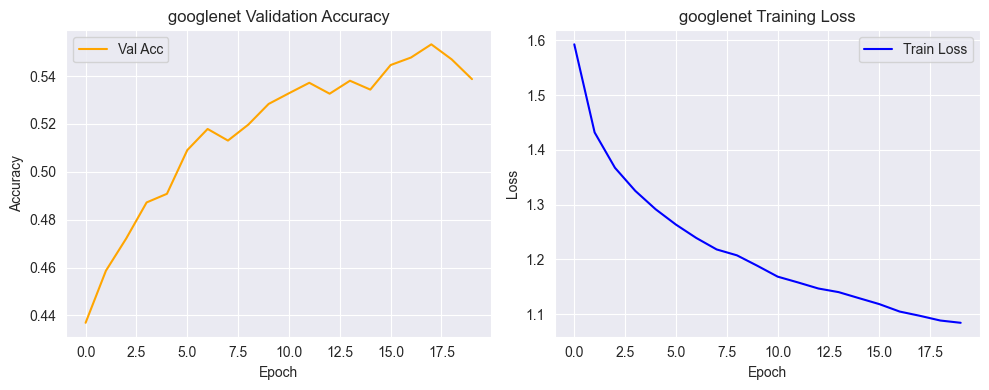

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]


Classification Report:

              precision    recall  f1-score   support

       angry       0.42      0.40      0.41       958
     disgust       0.39      0.48      0.43       111
        fear       0.41      0.30      0.34      1024
       happy       0.68      0.80      0.73      1774
     neutral       0.46      0.56      0.51      1233
         sad       0.49      0.26      0.34      1247
    surprise       0.57      0.74      0.64       831

    accuracy                           0.53      7178
   macro avg       0.49      0.51      0.49      7178
weighted avg       0.52      0.53      0.51      7178



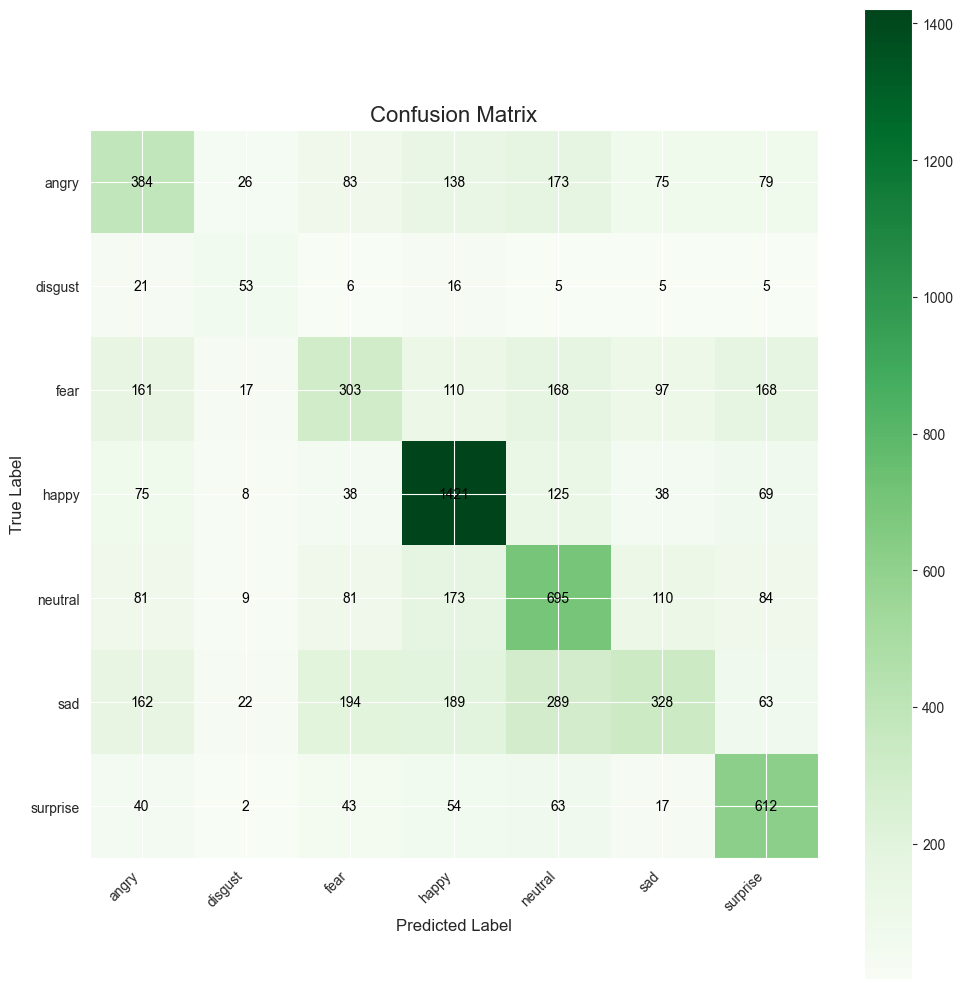


=== Training mobilenet_v2 ===
Epoch 1/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 1.4255 Acc: 0.4456


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.2762 Acc: 0.5066
Epoch 2/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 1.2315 Acc: 0.5266


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.1879 Acc: 0.5331
Epoch 3/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 1.1588 Acc: 0.5562


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.1337 Acc: 0.5545
Epoch 4/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 1.1093 Acc: 0.5753


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.0790 Acc: 0.5822
Epoch 5/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 1.0732 Acc: 0.5942


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.0601 Acc: 0.5901
Epoch 6/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 1.0458 Acc: 0.6033


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.0558 Acc: 0.5936
Epoch 7/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 1.0208 Acc: 0.6127


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.0373 Acc: 0.5958
Epoch 8/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 0.9954 Acc: 0.6211


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.0328 Acc: 0.5996
Epoch 9/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 0.9762 Acc: 0.6290


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.0114 Acc: 0.6047
Epoch 10/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 0.9626 Acc: 0.6344


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.0014 Acc: 0.6149
Epoch 11/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 0.9472 Acc: 0.6404


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 0.9961 Acc: 0.6123
Epoch 12/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 0.9264 Acc: 0.6508


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.0003 Acc: 0.6201
Epoch 13/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 0.9194 Acc: 0.6529


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 0.9825 Acc: 0.6253
Epoch 14/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 0.9079 Acc: 0.6597


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 0.9691 Acc: 0.6280
Epoch 15/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 0.8966 Acc: 0.6640


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 0.9548 Acc: 0.6323
Epoch 16/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 0.8779 Acc: 0.6702


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 0.9920 Acc: 0.6190
Epoch 17/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 0.8610 Acc: 0.6778


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 0.9632 Acc: 0.6346
Epoch 18/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 0.8535 Acc: 0.6800


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 0.9585 Acc: 0.6338
Epoch 19/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 0.8433 Acc: 0.6825


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 0.9626 Acc: 0.6280
Epoch 20/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 0.8325 Acc: 0.6891


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 0.9674 Acc: 0.6298


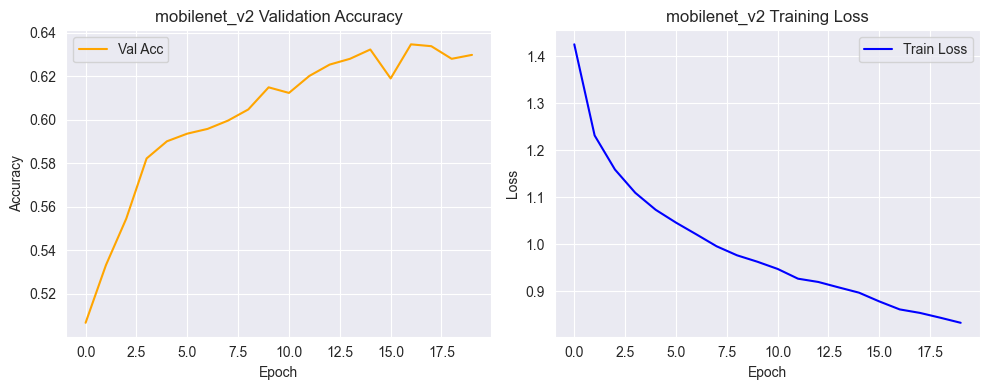

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]


Classification Report:

              precision    recall  f1-score   support

       angry       0.53      0.53      0.53       958
     disgust       0.52      0.42      0.47       111
        fear       0.52      0.35      0.42      1024
       happy       0.81      0.85      0.83      1774
     neutral       0.54      0.63      0.58      1233
         sad       0.50      0.50      0.50      1247
    surprise       0.72      0.78      0.75       831

    accuracy                           0.62      7178
   macro avg       0.59      0.58      0.58      7178
weighted avg       0.62      0.62      0.62      7178



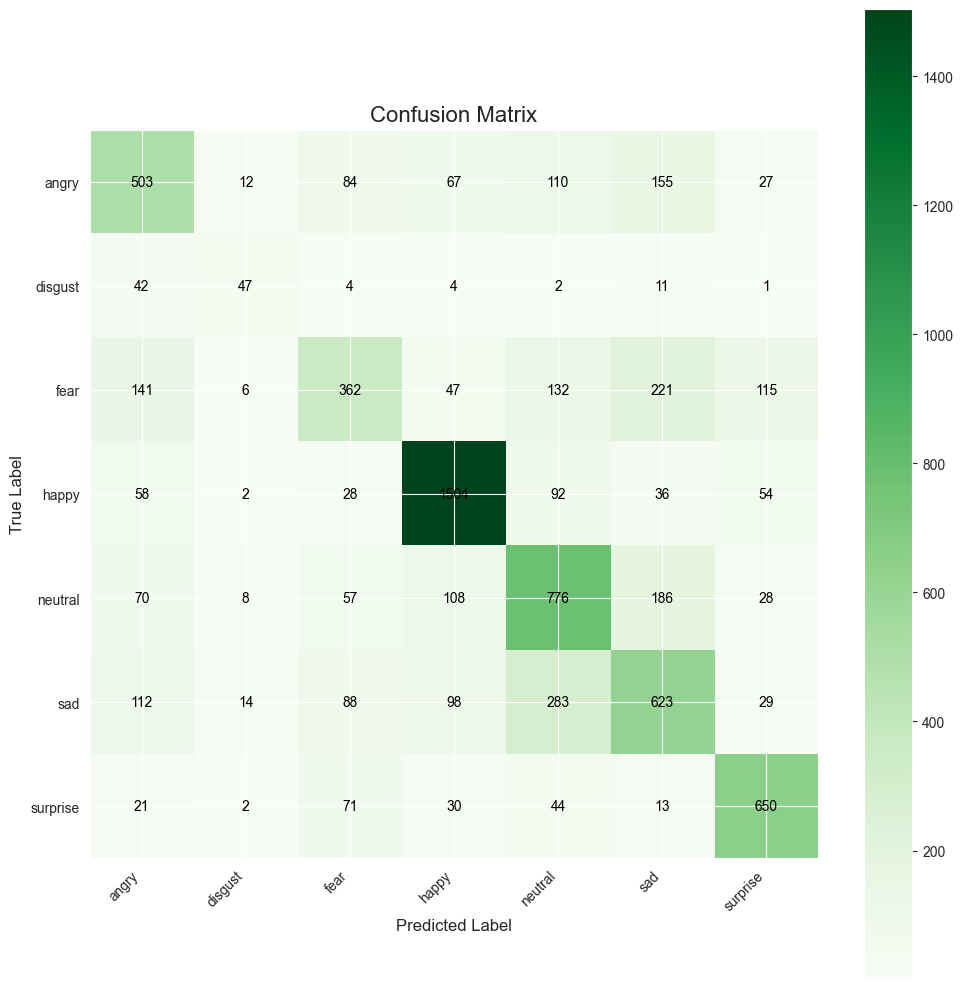


=== Training MyCustomCNN ===


AttributeError: module 'torchvision.models' has no attribute 'MyCustomCNN'

In [17]:
# --- Run Training ---
results = []
for name in ['efficientnet_b0','resnet18','googlenet','mobilenet_v2'] :
    print(f"\n=== Training {name} ===")
    model = load_model(name)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0008, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
    model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=20)


    val_acc = max(history['val_acc'])
    results.append({
        'name': name,
        'model': model,
        'history': history,
        'val_acc': val_acc
    })

    plot_training_curves(history, model_name=name)
    evaluate(model)

In [ ]:
# --- my custom model ---
class EmotionCNN(nn.Module):
    def __init__(self, num_classes):
        super(EmotionCNN, self).__init__()
        self.conv_block1 = self._conv_block(3, 32)
        self.conv_block2 = self._conv_block(32, 64)
        self.conv_block3 = self._conv_block(64, 128)
        self.conv_block4 = self._conv_block(128, 256)
        self.fc1 = self._fc_block(256 * 14 * 14, 512)
        self.fc2 = self._fc_block(512, 256)
        self.out = nn.Linear(256, num_classes)

    def _conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
        )

    def _fc_block(self, in_features, out_features):
        return nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.BatchNorm1d(out_features),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.out(x)
        return x



=== Training My model  ===
Epoch 1/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 1.7640 Acc: 0.2965


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.5282 Acc: 0.4007
Epoch 2/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 1.4857 Acc: 0.4237


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.4182 Acc: 0.4349
Epoch 3/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 1.3929 Acc: 0.4606


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.2860 Acc: 0.4913
Epoch 4/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 1.3433 Acc: 0.4833


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.2606 Acc: 0.5014
Epoch 5/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 1.3094 Acc: 0.4945


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.2118 Acc: 0.5233
Epoch 6/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 1.2736 Acc: 0.5107


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.1923 Acc: 0.5332
Epoch 7/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 1.2416 Acc: 0.5210


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.1577 Acc: 0.5480
Epoch 8/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 1.2151 Acc: 0.5316


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.1758 Acc: 0.5388
Epoch 9/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 1.1897 Acc: 0.5417


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.1310 Acc: 0.5591
Epoch 10/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 1.1723 Acc: 0.5502


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.0941 Acc: 0.5646
Epoch 11/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 1.1444 Acc: 0.5619


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.0739 Acc: 0.5810
Epoch 12/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 1.1175 Acc: 0.5739


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.0664 Acc: 0.5815
Epoch 13/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 1.1014 Acc: 0.5811


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.0642 Acc: 0.5790
Epoch 14/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 1.0850 Acc: 0.5869


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.0369 Acc: 0.5909
Epoch 15/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 1.0658 Acc: 0.5951


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.0098 Acc: 0.6034
Epoch 16/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 1.0505 Acc: 0.6004


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.0081 Acc: 0.6081
Epoch 17/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 1.0283 Acc: 0.6103


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.0083 Acc: 0.6091
Epoch 18/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 1.0192 Acc: 0.6139


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 0.9901 Acc: 0.6111
Epoch 19/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 1.0069 Acc: 0.6177


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 1.0116 Acc: 0.6046
Epoch 20/20


train:   0%|          | 0/658 [00:00<?, ?it/s]

train Loss: 0.9914 Acc: 0.6276


val:   0%|          | 0/165 [00:00<?, ?it/s]

val Loss: 0.9593 Acc: 0.6290


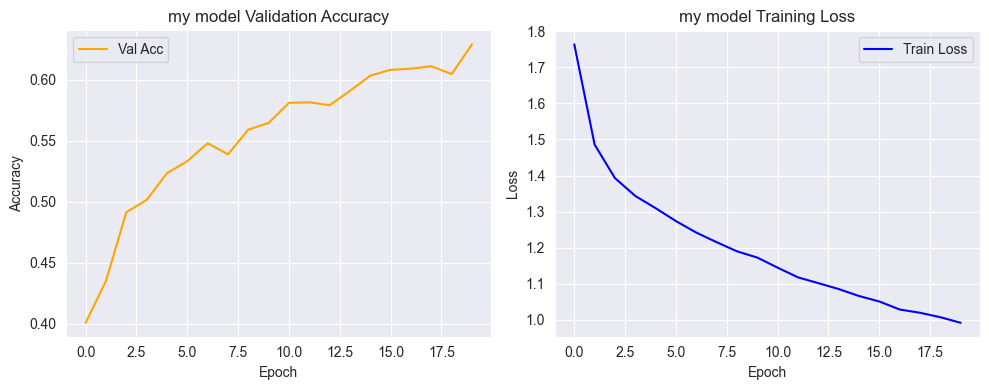

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]


Classification Report:

              precision    recall  f1-score   support

       angry       0.52      0.48      0.50       958
     disgust       0.56      0.60      0.58       111
        fear       0.50      0.28      0.36      1024
       happy       0.79      0.83      0.81      1774
     neutral       0.55      0.57      0.56      1233
         sad       0.46      0.53      0.49      1247
    surprise       0.69      0.80      0.74       831

    accuracy                           0.60      7178
   macro avg       0.58      0.59      0.58      7178
weighted avg       0.60      0.60      0.59      7178



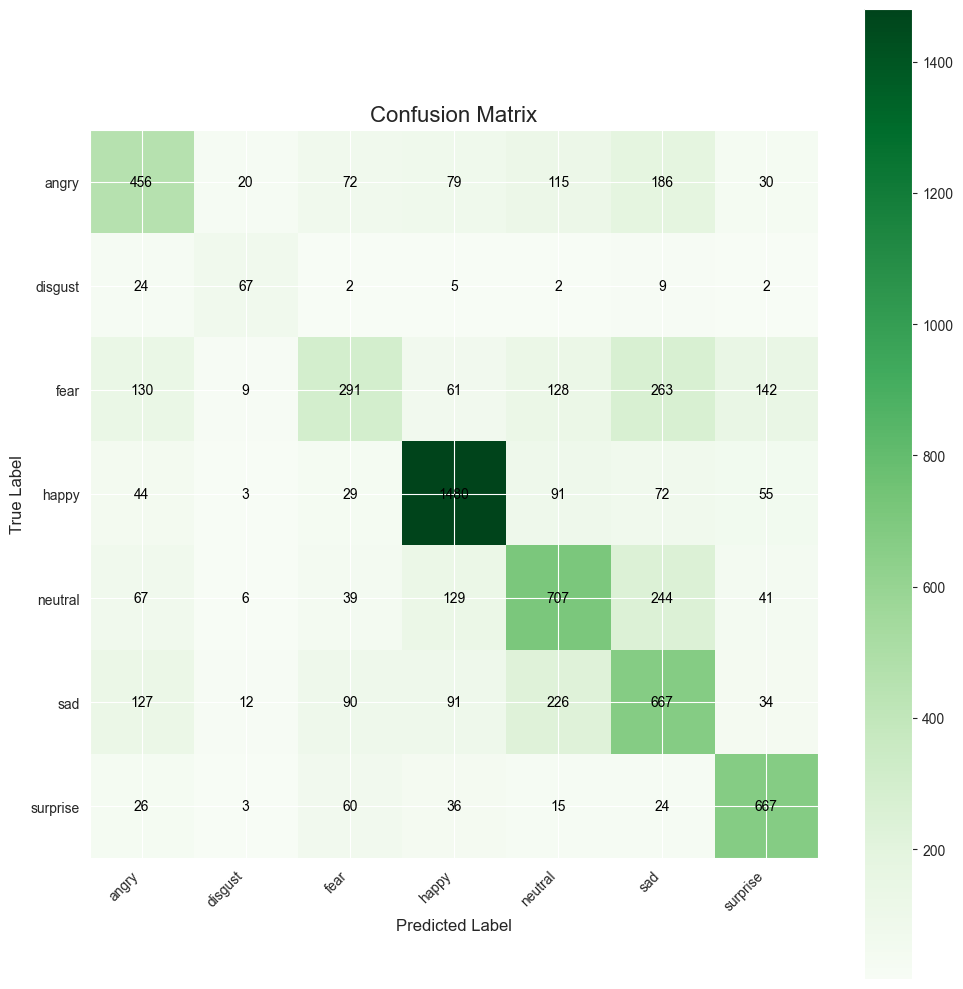

In [23]:
print(f"\n=== Training My model  ===")
model = EmotionCNN(n_classes)
model.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0008, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=20)


val_acc = max(history['val_acc'])
results.append({
    'name': name,
    'model': model,
    'history': history,
    'val_acc': val_acc
})

plot_training_curves(history, model_name='my model')
evaluate(model)

In [41]:
# --- Find Best Model ---
best = max(results, key=lambda x: x['val_acc'])

# Print all results
for res in results:
    print(f"{res['name']}: {res['val_acc']:.4f}")

print(f"\n Best model: {best['name']} with Val Acc: {best['val_acc']:.4f}")

efficientnet_b0: 0.7237
resnet18: 0.6651
googlenet: 0.5533
mobilenet_v2: 0.6346
MyCustomCNN: 0.6290

 Best model: efficientnet_b0 with Val Acc: 0.7237


In [36]:
# Save best model's weights only
torch.save(best['model'].state_dict(), f"best_model_{best['name']}.pt")
print(f"✅ Saved best model weights to best_model_{best['name']}.pt")

# Save full model (structure + weights) — optional
torch.save(best['model'], f"best_model_full_{best['name']}.pth")
print(f"✅ Saved full model to best_model_full_{best['name']}.pth")

# Save best model's training history
with open(f"{best['name']}_history.pkl", 'wb') as f:
    pickle.dump(best['history'], f)
print(f"✅ Saved training history to {best['name']}_history.pkl")

✅ Saved best model weights to best_model_efficientnet_b0.pt
✅ Saved full model to best_model_full_efficientnet_b0.pth
✅ Saved training history to efficientnet_b0_history.pkl
